<div style="text-align: center;">
    <h1> Red neuronal - Temperatura en subsuelo y aire / Profundidad de la nieve en zona de la Patagonia, Chile </h1>
</div>

<p> La Patagonia es una vasta región geográfica ubicada en el extremo sur de América del Sur, compartida por Argentina y Chile. Conocida por su impresionante diversidad geográfica que incluye montañas, glaciares, lagos y extensas estepas, la Patagonia representa un área de interés científico y ambiental significativo. Este entorno único ofrece condiciones ideales para el estudio de diversos fenómenos climáticos y meteorológicos, entre ellos, la dinámica de la nieve. </p>

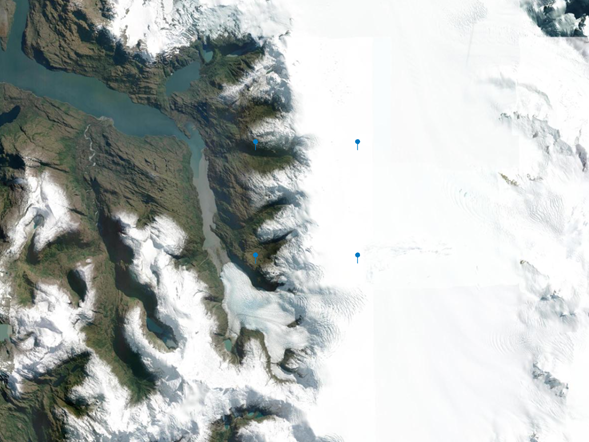

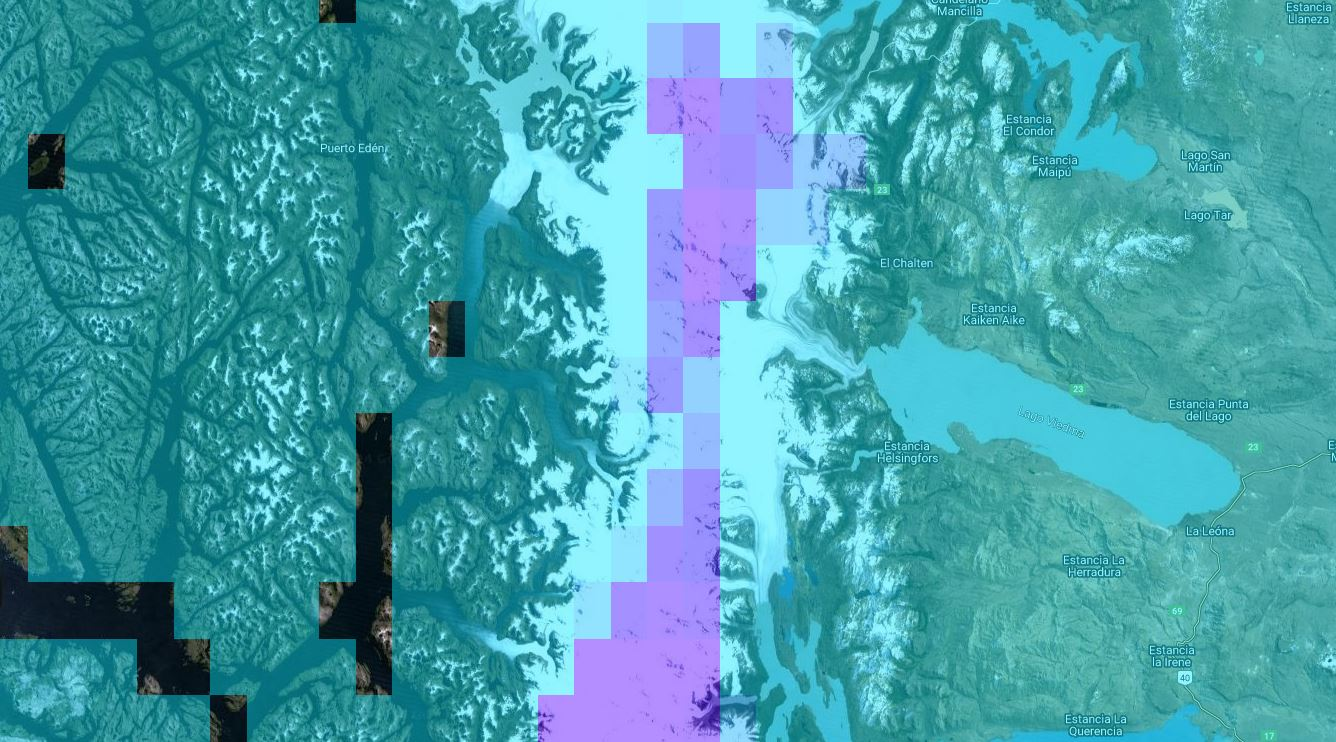

In [17]:
from IPython.display import Image
from IPython.display import display
x = Image(filename=("./Img/Zona_Estudio.png"), width = 600, height = 300) 
y = Image(filename=("./Img/Profundidad_Hielo_GEE.jpg"), width = 600, height = 300) 
display(x, y)

<p> La región patagónica alberga algunos de los campos de hielo más grandes fuera de las regiones polares, como el Campo de Hielo Patagónico Sur. Estos glaciares son cruciales para los recursos hídricos locales, y la nieve desempeña un papel vital en su dinámica. El estudio de la nieve en esta región ayuda a comprender mejor los procesos de alimentación y retracción de los glaciares, lo cual es esencial para la gestión del agua en el contexto del cambio climático. </p>

In [184]:
# Librerias
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objs as go

import ee
# ee.Authenticate()
ee.Initialize()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import r2_score, explained_variance_score, max_error, median_absolute_error

np.random.seed(123)
tf.random.set_seed(123)

In [ ]:
# Función para extraer la media de las variables de:
#   - Temperatura del suelo (100 - 200 cm bajo tierra)
#   - Temperatura del aire cerca de la superficie
#   - Profundidad de la nieve

def calcular_media_mensual(image):
    date = ee.Date(image.get('system:time_start'))
    month = date.format('MM')
    SoilTemp100_200cm_tavg = image.select('SoilTemp100_200cm_tavg').reduceRegion(reducer=ee.Reducer.mean(), geometry = rectangle, scale = 1000).get('SoilTemp100_200cm_tavg')
    Tair_f_tavg = image.select('Tair_f_tavg').reduceRegion(reducer=ee.Reducer.mean(), geometry = rectangle, scale = 1000).get('Tair_f_tavg')
    SnowDepth_inst = image.select('SnowDepth_inst').reduceRegion(reducer=ee.Reducer.mean(), geometry = rectangle, scale = 1000).get('SnowDepth_inst')
    return ee.Feature(None, {'month': month, 'SoilTemp100_200cm_tavg': SoilTemp100_200cm_tavg, 'Tair_f_tavg': Tair_f_tavg, 'SnowDepth_inst': SnowDepth_inst})

def get_top_indices(metric, ascending=True):
    return results_df.nsmallest(3, metric) if ascending else results_df.nlargest(3, metric)

In [179]:
collection = ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001")
xmin, ymin, xmax, ymax = -73.745041,-49.407846,-73.675003,-49.357334 # Área de estudio
# xmin, ymin, xmax, ymax = -73.442574,-47.491457,-73.371506,-47.432268
# xmin, ymin, xmax, ymax = -73.862801,-48.541614,-73.760490,-48.510009

rectangle = ee.Geometry.Rectangle([xmin, ymin, xmax, ymax])

filtered_collection = collection.filterBounds(rectangle).filterDate('1982-01-01', '2024-01-01') # Ventana temporal a estudiar

monthly_stats = filtered_collection.map(calcular_media_mensual)
stats_list = monthly_stats.getInfo()
data = []

for item in stats_list['features']:
    month = item['properties']['month']
    SoilTemp100_200cm_tavg = item['properties']['SoilTemp100_200cm_tavg']
    Tair_f_tavg = item['properties']['Tair_f_tavg']
    SnowDepth_inst = item['properties']['SnowDepth_inst']
    year = item['id'][:4]
    data.append({'year': year, 'month': month, 'SoilTemp100_200cm_tavg': SoilTemp100_200cm_tavg, 'Tair_f_tavg': Tair_f_tavg, 'SnowDepth_inst': SnowDepth_inst})

df = pd.DataFrame(data)

<div style="text-align: center;">
    <p><strong> Gráfico de comparación de temperaturas con la profundidad de la nieve: </strong> Conforme a la revisión de variables expuestas en el servicio de GEE de FLDAS, se pretende caracterizar el comportamiento de la profundidad de la nieve partiendo del comportamiento de la temperatura promedio mensual encontrada en un fragmento de La Patagonia.</p>
    <p> La Patagonia es una región con hermosos glaciares que permite entender el comportamiento de la nieve.  </p>
</div>

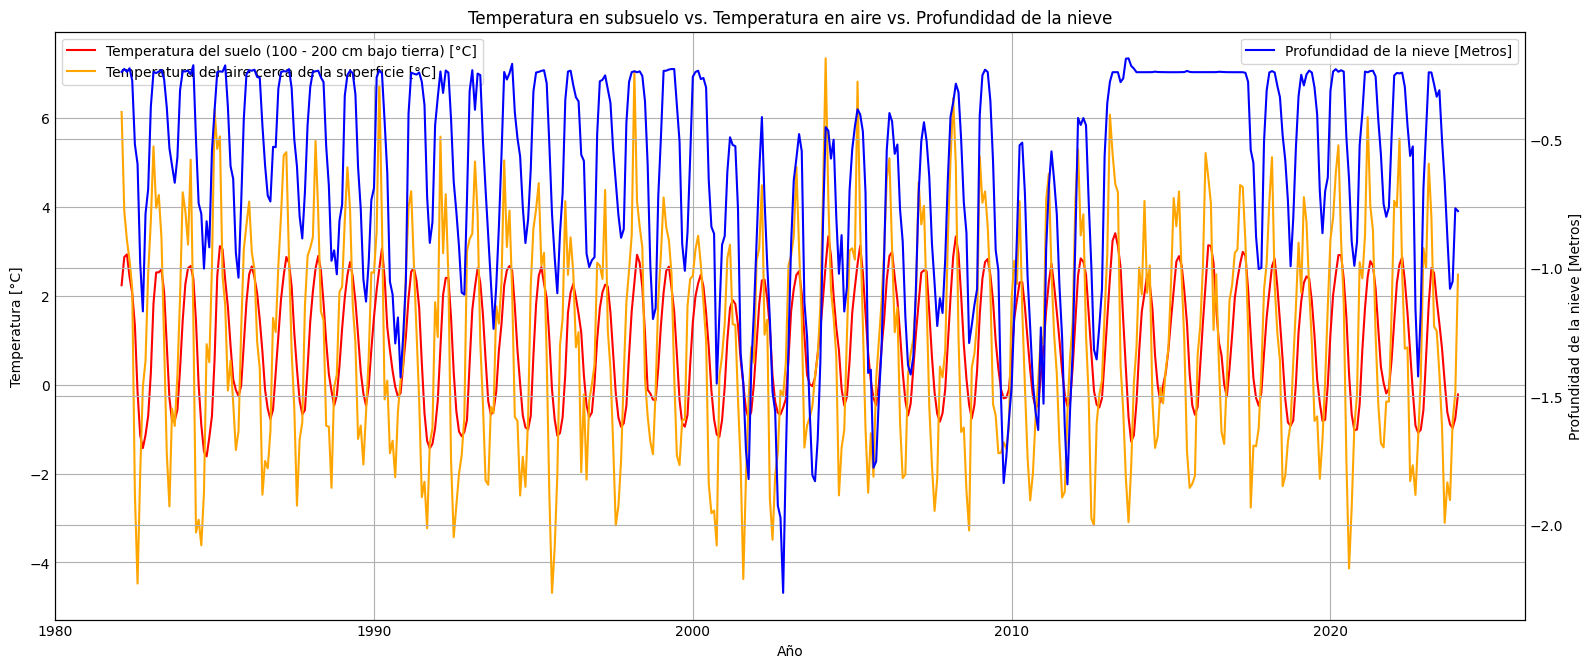

In [180]:
df['month'] = df['month'].astype(int)
df['year'] = df['year'].astype(int)
fig, ax1 = plt.subplots(figsize=(15, 6)) 

ax1.plot(df['year'] + df['month']/12, df['SoilTemp100_200cm_tavg'] - 273.15, label = 'Temperatura del suelo (100 - 200 cm bajo tierra) [°C]', color = 'red')
ax1.plot(df['year'] + df['month']/12, df['Tair_f_tavg'] - 273.15, label='Temperatura del aire cerca de la superficie [°C]', color = 'orange')

ax2 = ax1.twinx()
ax2.plot(df['year'] + df['month']/12, -1*df['SnowDepth_inst'], label='Profundidad de la nieve [Metros]', color='blue')

ax1.set_xlabel('Año')
ax1.set_ylabel('Temperatura [°C]')
ax2.set_ylabel('Profundidad de la nieve [Metros]')
ax1.set_title('Temperatura en subsuelo vs. Temperatura en aire vs. Profundidad de la nieve')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

<div style="text-align: center;">
    <p> En el fragmento del año 2000 - 2005 es posible visualizar una reducción en los valores de la temperatura, tanto a nivel del subsuelo como a nivel superficial; mientras que, el hielo presentó valores de profundidad más altos, es decir, mayor cantidad de hielo. Por otro lado, en intervalos donde la temperatura incrementó sus valores, se observan cifras para la profundidad menores, indicando menor cantidad de hielo para dicho intervalo temporal  </p>
</div>

In [181]:
df['SoilTemp100_200cm_tavg_squared'] = df['SoilTemp100_200cm_tavg']**2
df['Tair_f_tavg_squared'] = df['Tair_f_tavg']**2
df['SoilTemp100_200cm_tavg_Tair_f_tavg'] = df['SoilTemp100_200cm_tavg'] * df['Tair_f_tavg']
df['SoilTemp100_200cm_tavg'] = df['SoilTemp100_200cm_tavg'] - 273.15
df['Tair_f_tavg'] = df['Tair_f_tavg'] - 273.15 

In [185]:
X = df[['SoilTemp100_200cm_tavg', 'Tair_f_tavg', 'SoilTemp100_200cm_tavg_squared', 'Tair_f_tavg_squared', 'SoilTemp100_200cm_tavg_Tair_f_tavg']]
y = df['SnowDepth_inst']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [186]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<div style="text-align: center;">
    <p> Se construye la función que permite generar la arquitectura de la red con 3, 6, 5, 1 unidades. Dicha funcionalidad permite variar la función de activación para una tasa de aprendizaje de 0.01 y 500 epocas, una vez se ejecuta el entrenamiento, se almacena en la carpeta "Models" los resultados para cada función para que pueda ser utilizado posteriormente.  </p>
</div>

In [201]:
def build_and_train_model(activation_function, learning_rate=0.01, epochs=500, batch_size=15):
    model = Sequential()
    model.add(Dense(3, input_dim=X_train.shape[1], activation=activation_function, kernel_regularizer=l2(0.01)))
    model.add(Dense(6, activation=activation_function, kernel_regularizer=l2(0.01)))
    model.add(Dense(5, activation=activation_function, kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=MeanSquaredError())
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3, verbose=0)
    
    loss = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test)

    model.save(f'Models/model_{activation_function}.h5')

    return loss, y_pred, history

<p><strong> 1. Definición del Modelo: </strong></p>
   <p> - 'model = Sequential()': Se crea un modelo secuencial, que es el tipo más simple de modelo en Keras, adecuado para una pila lineal de capas.</p>
 
<p><strong> 2. Capas del Modelo: </strong>
   <p>   - 'model.add(Dense(3, input_dim=X_train.shape[1], activation=activation_function, kernel_regularizer=l2(0.01)))':</p>
   <p>   - Añade una capa densa con 3 unidades.</p>
   <p>   - 'input_dim = X_train.shape[1]' especifica la dimensión de entrada, que coincide con el número de características en los datos de entrenamiento.</p>
   <p>   - 'activation = activation_function' define la función de activación, la cual es un parámetro variable en la función.</p>
   <p>   - 'kernel_regularizer = l2(0.01)' añade regularización L2 a los pesos para prevenir el sobreajuste.</p>
   <p>   - Se añaden otras dos capas densas con 6 y 5 unidades respectivamente, utilizando la misma función de activación y regularización.</p>
   <p>   - 'model.add(Dense(1, activation='linear'))': La capa de salida tiene una unidad (una única salida) y utiliza una función de activación lineal, adecuada para regresión.</p>
 
<p><strong> 3. Compilación del Modelo: </strong></p>
   <p>   - 'optimizer = Adam(learning_rate=learning_rate)': Se define el optimizador Adam con una tasa de aprendizaje especificada.</p>
   <p>   - 'model.compile(optimizer=optimizer, loss=MeanSquaredError())': Compila el modelo utilizando el optimizador Adam y la función de pérdida de error cuadrático medio (MSE). </p>
 
<p><strong> 4. Entrenamiento del Modelo: </strong></p>
<p>   - 'history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3, verbose=0)':</p>
     <p> - Entrena el modelo con los datos de entrenamiento ('X_train', 'y_train').</p>
     <p> - 'epochs=500': Número de épocas de entrenamiento.</p>
     <p> - 'batch_size=15': Tamaño del lote para la actualización de los gradientes.</p>
     <p> - 'validation_split=0.3': Se usa el 30% de los datos de entrenamiento para validación.</p>
     <p>- 'verbose=0': No muestra detalles durante el entrenamiento. </p>
 
<p><strong>5. Evaluación y Predicción: </strong></p>
   <p>   - 'loss = model.evaluate(X_test, y_test, verbose=0)': Evalúa el modelo con los datos de prueba y retorna el valor de la pérdida.</p>
   <p>   - 'y_pred = model.predict(X_test)': Realiza predicciones sobre los datos de prueba.</p>
 
<p><strong> 6. Guardado del Modelo: </strong></p>
   <p> - 'model.save(f'Models/model_{activation_function}.h5')': Guarda el modelo entrenado en un archivo .h5, utilizando el nombre de la función de activación en el nombre del archivo.</p>
 
<p><strong> 7. Retorno de Resultados:</strong></p>
   <p> - 'return loss, y_pred, history': Retorna la pérdida en los datos de prueba, las predicciones y el historial de entrenamiento.</p>
  con un enfoque en la prevención del sobreajuste y una evaluación robusta del rendimiento del modelo mediante diversas métricas.

In [202]:
# Funciones de activación utilizadas
activation_functions = ['elu',  'gelu', 'hard_sigmoid', 'hard_silu', 'hard_swish', 'leaky_relu', 'linear', 'log_softmax', 'mish', 'relu6', 'softmax', 'swish']

<html lang="es">
<head>
    <meta charset="UTF-8">
    <title>Métricas de Precisión en Regresión</title>
</head>
<body>
 
<h1>Métricas de Precisión en Regresión</h1>
<h2>1. r2_score</h2>
<p>El r2_score representa la proporción de varianza (de y) que ha sido explicada por las variables independientes en el modelo. Proporciona una indicación de qué tan bien se ajustan las muestras no vistas al modelo, a través de la proporción de varianza explicada. El mejor puntaje posible es 1.0 y puede ser negativo. Un modelo constante que siempre predice el valor esperado (promedio) de y, sin tener en cuenta las características de entrada, obtendría un puntaje de 0.0.</p>
 
<h3>Fórmula:</h3>

$
R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}
$

<h3>Código:</h3>
<pre>
    from sklearn.metrics import r2_score
    y_true = [3, -0.5, 2, 7]
    y_pred = [2.5, 0.0, 2, 8]
    print(r2_score(y_true, y_pred))  # Output: 0.948...
    
</pre>
 
<h2>2. explained_variance_score</h2>
<p>La función de puntuación de varianza explicada en regresión. El mejor puntaje posible es 1.0, los valores más bajos son peores. La puntuación de varianza explicada es similar al puntaje R^2, con la notable diferencia de que no tiene en cuenta los desajustes sistemáticos en la predicción.</p>
 
<h3>Fórmula:</h3>

$
EVS = 1 - \frac{Var(y - \hat{y})}{Var(y)}
$

<h3>Código:</h3>
<pre>
    from sklearn.metrics import explained_variance_score
    y_true = [3, -0.5, 2, 7]
    y_pred = [2.5, 0.0, 2, 8]
    print(explained_variance_score(y_true, y_pred))  # Output: 0.957...
    
</pre>
 
<h2>3. max_error</h2>
<p>El max_error computa el error residual máximo, una métrica que captura el peor caso de error entre el valor predicho y el valor real.</p>
 
<h3>Fórmula:</h3>

$
Max Error = max(|y_i - \hat{y}_i|)
$ 


<h3>Código:</h3>
<pre>
    from sklearn.metrics import max_error
    y_true = [3, 2, 7, 1]
    y_pred = [9, 2, 7, 1]
    print(max_error(y_true, y_pred))  # Output: 6
    
</pre>
 
<h2>4. median_absolute_error</h2>
<p>El median_absolute_error es particularmente interesante porque es robusto a los valores atípicos. La pérdida se calcula tomando la mediana de todas las diferencias absolutas entre el objetivo y la predicción.</p>
 
<h3>Fórmula:</h3>


$
MedAE = median(|y_i - \hat{y}_i|)
$

<h3>Código:</h3>
<pre>
    from sklearn.metrics import median_absolute_error
    y_true = [3, -0.5, 2, 7]
    y_pred = [2.5, 0.0, 2, 8]
    print(median_absolute_error(y_true, y_pred))  # Output: 0.5
    
</pre>
</body>
</html>

In [204]:
results = []
predictions = {}
histories = {}
r2_scores = []
explained_variance_scores = []
max_errors = []
median_absolute_errors = []

for func in activation_functions:
    loss, y_pred, history = build_and_train_model(func)
    predictions[func] = y_pred.flatten()
    histories[func] = history
    r2 = r2_score(y_test, predictions[func])
    explained_variance = explained_variance_score(y_test, predictions[func])
    max_error_value = max_error(y_test, predictions[func])
    medae = median_absolute_error(y_test, predictions[func])

    results.append({
        'activation_function': func,
        'loss': loss,
        'r2_score': r2,
        'explained_variance_score': explained_variance,
        'max_error': max_error_value,
        'median_absolute_error': medae
    })

    print(f'Función de activación: {func}, Loss: {loss}, R^2: {r2}, Explained Variance: {explained_variance}, Max Error: {max_error_value}, MedAE: {medae}')

results_df = pd.DataFrame(results)
best_activation_function = results_df.loc[results_df['loss'].idxmin(), 'activation_function']
best_loss = results_df.loc[results_df['loss'].idxmin(), 'loss']
best_r2_score = results_df.loc[results_df['loss'].idxmin(), 'r2_score']
print(f'La mejor función de activación es: {best_activation_function} con un loss de: {best_loss} y un R^2 de: {best_r2_score}')
best_predictions = predictions[best_activation_function]

c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


Función de activación: elu, Loss: 0.11726509779691696, R^2: 0.3754149250417351, Explained Variance: 0.39430702947897656, Max Error: 1.2587139046360263, MedAE: 0.178840756434969


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


Función de activación: gelu, Loss: 0.11979502439498901, R^2: 0.3711683410367298, Explained Variance: 0.3877063576094566, Max Error: 1.2669349348713168, MedAE: 0.17919173678399059


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


Función de activación: hard_sigmoid, Loss: 0.17775727808475494, R^2: -0.00020592630380522614, Explained Variance: 1.1102230246251565e-16, Max Error: 1.6277640497852572, MedAE: 0.3600170123037456


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


Función de activación: hard_silu, Loss: 0.12394686788320541, R^2: 0.3479074337692135, Explained Variance: 0.38177406530579283, Max Error: 1.2449067270923861, MedAE: 0.20108041313018232


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


Función de activación: hard_swish, Loss: 0.12183743715286255, R^2: 0.3615594987784766, Explained Variance: 0.3901801262449124, Max Error: 1.266126576678873, MedAE: 0.19495887491331576


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Función de activación: leaky_relu, Loss: 0.11233553290367126, R^2: 0.4044584637406078, Explained Variance: 0.4141533163054547, Max Error: 1.2314097321201571, MedAE: 0.1438921691187654


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Función de activación: linear, Loss: 0.12030074745416641, R^2: 0.3596070301234958, Explained Variance: 0.3864774790724256, Max Error: 1.2565105593372592, MedAE: 0.19509316020832274


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Función de activación: log_softmax, Loss: 0.12860657274723053, R^2: 0.3318891809990754, Explained Variance: 0.3843086506411312, Max Error: 1.2285873329807528, MedAE: 0.2214659646263361


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Función de activación: mish, Loss: 0.12123722583055496, R^2: 0.3609434915924089, Explained Variance: 0.38896436199467277, Max Error: 1.2487191593815097, MedAE: 0.19360668133387143


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Función de activación: relu6, Loss: 0.11352493613958359, R^2: 0.40188910547490453, Explained Variance: 0.4178291066351363, Max Error: 1.224162522571207, MedAE: 0.15905311116892315


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Función de activación: softmax, Loss: 0.17776261270046234, R^2: -0.00023571009190237469, Explained Variance: 1.1102230246251565e-16, Max Error: 1.6281867659260043, MedAE: 0.35959429616299854


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


Función de activación: swish, Loss: 0.12187785655260086, R^2: 0.36343494473536975, Explained Variance: 0.385121716872839, Max Error: 1.2620355522800693, MedAE: 0.1881264479438502
La mejor función de activación es: leaky_relu con un loss de: 0.11233553290367126 y un R^2 de: 0.4044584637406078


In [205]:
results_df

,activation_function,loss,r2_score,explained_variance_score,max_error,median_absolute_error
0,elu,0.117265,0.375415,3.943070e-01,1.258714,0.178841
1,gelu,0.119795,0.371168,3.877064e-01,1.266935,0.179192
2,hard_sigmoid,0.177757,-0.000206,1.110223e-16,1.627764,0.360017
3,hard_silu,0.123947,0.347907,3.817741e-01,1.244907,0.201080
4,hard_swish,0.121837,0.361559,3.901801e-01,1.266127,0.194959
5,leaky_relu,0.112336,0.404458,4.141533e-01,1.231410,0.143892
6,linear,0.120301,0.359607,3.864775e-01,1.256511,0.195093
7,log_softmax,0.128607,0.331889,3.843087e-01,1.228587,0.221466
8,mish,0.121237,0.360943,3.889644e-01,1.248719,0.193607
9,relu6,0.113525,0.401889,4.178291e-01,1.224163,0.159053


<p> 1. La elección de la función de activación tiene un impacto significativo en el rendimiento del modelo. Por ejemplo, las funciones de activación 'hard_sigmoid' y 'softmax' mostraron un bajo rendimiento en términos de 'r2_score' y 'explained_variance_score', lo que sugiere que estas funciones pueden no ser adecuadas para este problema específico.</p>
 
<p>2. La métrica 'max_error' revela el peor caso de error entre la profundidad de la nieve predicha y la profundidad real. Observamos que todas las funciones de activación muestran valores bajos para esta métrica, lo que indica que el modelo tiende a cometer errores pequeños en la predicción de la profundidad de la nieve, independientemente de la función de activación utilizada. No obstante, los "pequeños errores" se asocian a que el área seleccionada comprende algunas muestras con valor de profundidad comparativamente pequeño. </p>
 
<p>3. La métrica 'median_absolute_error' proporciona una medida robusta de la precisión del modelo, ya que es menos sensible a los valores atípicos. En este caso, se observa que la función de activación 'leaky_relu' muestra el valor más bajo para esta métrica, lo que sugiere que puede ser una buena opción cuando se desea minimizar el impacto de valores atípicos en la predicción.</p>
 
<p>4. Aunque la métrica 'r2_score' y 'explained_variance_score' proporcionan una medida de la capacidad del modelo para explicar la variabilidad en los datos, es importante considerar también otras métricas para obtener una imagen completa del rendimiento del modelo. En este caso, vemos que algunas funciones de activación, como 'linear', tienen valores relativamente altos para estas métricas, pero aún así muestran un rendimiento deficiente en otras métricas, como 'max_error' y 'median_absolute_error', lo que sugiere que el modelo puede estar sesgado o no capturar adecuadamente la variabilidad en los datos.</p>

C:\Users\ingju\AppData\Local\Temp\ipykernel_81560\1167317116.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(results_df['activation_function'], rotation=45)
C:\Users\ingju\AppData\Local\Temp\ipykernel_81560\1167317116.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(results_df['activation_function'], rotation=45)
C:\Users\ingju\AppData\Local\Temp\ipykernel_81560\1167317116.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(results_df['activation_function'], rotation=45)
C:\Users\ingju\AppData\Local\Temp\ipykernel_81560\1167317116.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLoc

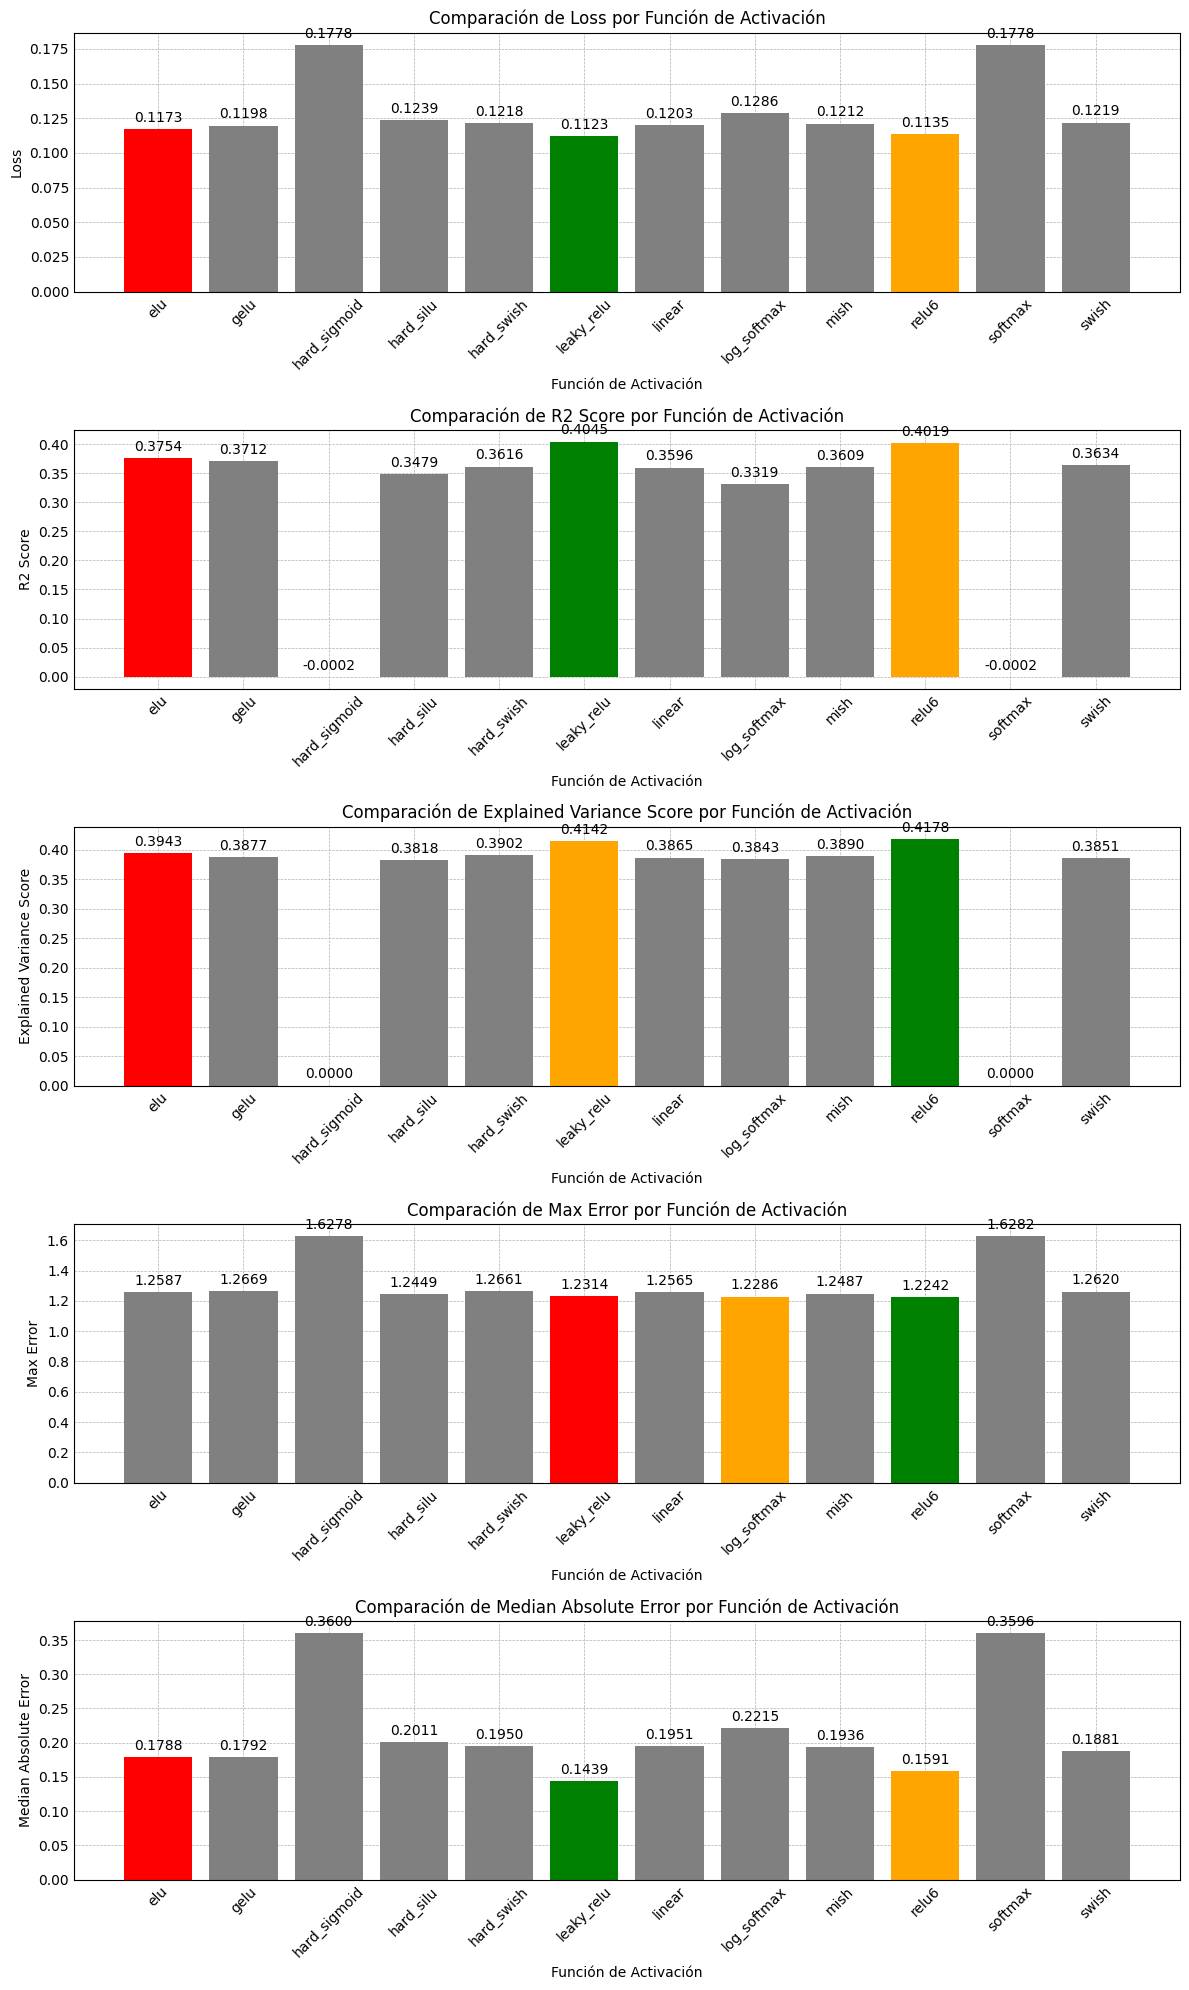

In [206]:
metrics = ['loss', 'r2_score', 'explained_variance_score', 'max_error', 'median_absolute_error']
num_metrics = len(metrics)

top_colors = ['green', 'orange', 'red']
default_color = 'gray'



fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 4 * num_metrics))
axes = axes if num_metrics > 1 else [axes]

for i, metric in enumerate(metrics):
    ascending = metric in ['loss', 'max_error', 'median_absolute_error']
    top_results = get_top_indices(metric, ascending=ascending)
    top_indices = top_results.index.tolist()
    
    colors = [top_colors[top_indices.index(idx)] if idx in top_indices else default_color for idx in results_df.index]
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    bars = axes[i].bar(results_df['activation_function'], results_df[metric], color=colors)
    axes[i].set_title(f'Comparación de {metric.replace("_", " ").title()} por Función de Activación')
    axes[i].set_xlabel('Función de Activación')
    axes[i].set_ylabel(metric.replace("_", " ").title())
    axes[i].set_xticklabels(results_df['activation_function'], rotation=45)
    
    for bar, idx in zip(bars, results_df.index):
        height = bar.get_height()
        axes[i].annotate(f'{height:.4f}', 
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')
    
plt.tight_layout()
plt.show()

<p> Se busca que con cimiento en los valores de las métricas derivadas del uso de cada una de las funciones de activación, se identifiquen los 3 modelos con mejores resultados organizados por color (Verde, naranja y rojo) </p>

<p> Según la medidas de Loss, R2 Score y la varianza explicada , las tres mejores funciones de activación comprenden Leaky relu, relu6 y elu. Por otro lado, las funciones con los valores de error máximo más bajo comprenden Leaky relu, log softmax y relu6, mostrando un error entre 1.2242 a 1.2314 metros en la profundidad predicha. </p>

<p> Por otro lado, el R2 Score mayor entre las ejecuciones, corresponde a Leaky relu, con 0.4045. Lo anterior ilustra que la temperatura tiene una influencia leve sobre la profundidad de la nieve, sin embargo, esto podría mejorar si se adicionan covariables que complementen y ayuden a caracterizar de mejor forma el comportamiento de la profundidad, tal como, la precipitación, la radiación, entre otros. </p>

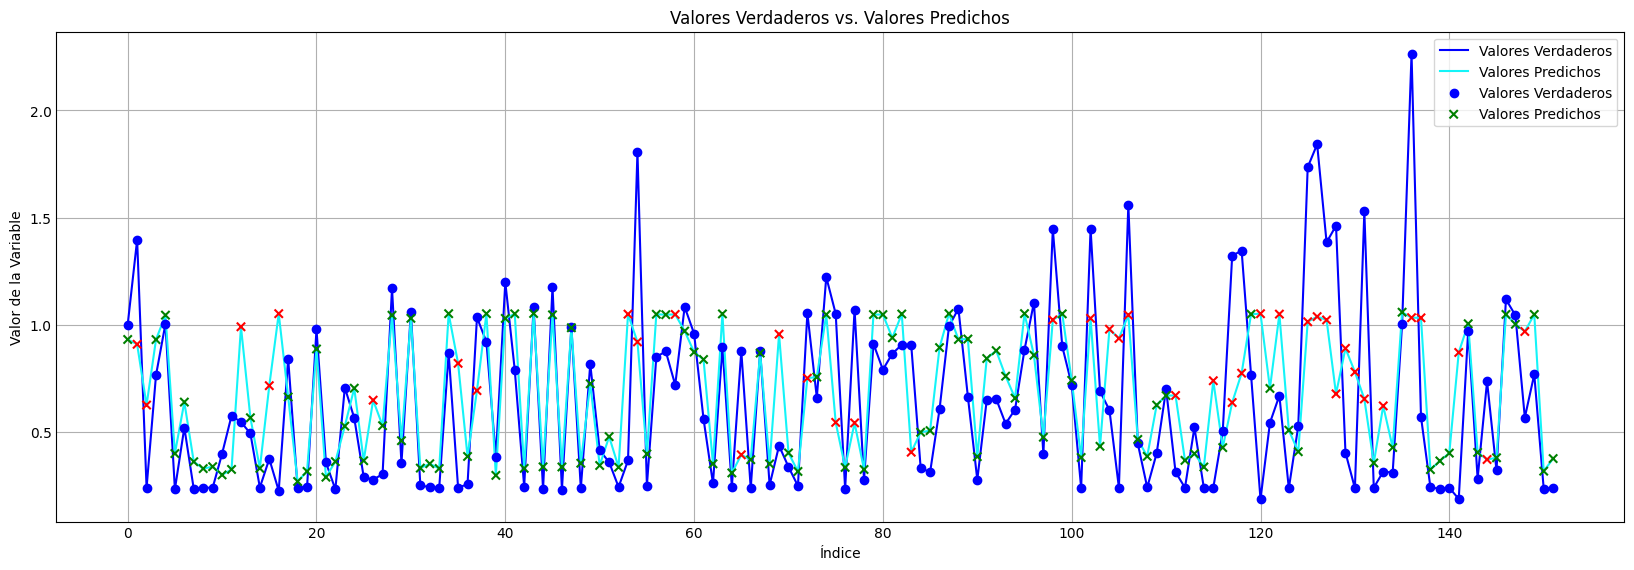

In [207]:
errors = np.abs(y_test.values - best_predictions)
colors = ['green' if error < 0.3 else 'red' for error in errors]

plt.figure(figsize=(16, 5))
plt.plot(y_test.values, label='Valores Verdaderos', color='blue')
plt.plot(best_predictions, label='Valores Predichos', color='#14F4F8')

plt.scatter(range(len(y_test)), y_test.values, label='Valores Verdaderos', marker='o', color='blue', zorder=5)
plt.scatter(range(len(best_predictions)), best_predictions, label='Valores Predichos', marker='x', color=colors, zorder=5)

plt.xlabel('Índice')
plt.ylabel('Valor de la Variable')
plt.title('Valores Verdaderos vs. Valores Predichos')
plt.legend()
plt.show()

<p> Al momento de graficar los valores de profundidad del hielo de la serie extraida y las predicciones generadas por el modelo de menor pérdida, encontramos diferencias inferiores a 0.3 m en la mayoría de registros (Registros verdes), no obstante, el error es significativo, lo cual puede explicarse por la capacidad de explicación de las variables de temperatura </p>

In [219]:
loss_traces = []
legend_names = []

plt.figure(figsize = (16, 6))
for func, color in zip(activation_functions, colors):
    loss_trace_train = go.Scatter(
        x = list(range(len(histories[func].history['loss']))),
        y = histories[func].history['loss'],
        mode = 'lines',
        name = f'{func} - Train Loss',
        line = dict(color=color)
    )
    loss_traces.append(loss_trace_train)
    legend_names.append(f'{func} - Train Loss')

    loss_trace_val = go.Scatter(
        x = list(range(len(histories[func].history['val_loss']))),
        y = histories[func].history['val_loss'],
        mode = 'lines',
        name = f'{func} - Val Loss',
        line = dict(color=color, dash='dash')
    )
    loss_traces.append(loss_trace_val)
    legend_names.append(f'{func} - Val Loss')

layout = go.Layout(
    title = 'Función de Pérdida para cada Modelo',
    xaxis = dict(title='Épocas'),
    yaxis = dict(title='Pérdida'),
    hovermode = 'closest',
    legend = dict(
        orientation="v",
        x = 1.05,
        y = 1
    )
)

fig = go.Figure(data=loss_traces, layout=layout)
fig.show()


<Figure size 1600x600 with 0 Axes>


### Implicaciones de los valores otorgados en la red neuronal
 
1. Funciones de Activación:
   - La función de activación influye en cómo los nodos de la red procesan la entrada. Diferentes funciones de activación pueden resultar en modelos con diferentes capacidades de generalización y ajuste a los datos.
 
2. Regularización L2:
   - La regularización L2 penaliza grandes valores de los pesos para prevenir el sobreajuste. El valor 0.01 es un hiperparámetro que controla la cantidad de penalización.
 
3. Tasa de Aprendizaje:
   - La tasa de aprendizaje del optimizador Adam afecta la velocidad y estabilidad del entrenamiento. Una tasa de aprendizaje de 0.01 es un valor común que puede ajustarse según los resultados.
 
4. Métricas de Evaluación:
   - 'loss': La pérdida MSE en los datos de prueba indica qué tan bien el modelo predice las profundidades de la nieve.
   - 'r2_score': Proporción de la varianza explicada por el modelo.
   - 'explained_variance_score': Similar al 'r2_score', pero sin considerar los desajustes sistemáticos.
   - 'max_error': Mide el mayor error absoluto en las predicciones.
   - 'median_absolute_error': Mediana de los errores absolutos, robusta a valores atípicos.
 
### Conclusiones
 
1. Elección de la Función de Activación:
   - Funciones como 'leaky_relu' y 'relu6' mostraron mejor rendimiento en términos de pérdida y 'r2_score', lo que sugiere que son más adecuadas para este problema específico de regresión.
 
2. Regularización y Arquitectura:
   - La inclusión de regularización L2 ayuda a prevenir el sobreajuste, especialmente con una arquitectura de red relativamente simple pero profunda.
 
3. Parámetros del Modelo:
   - El uso de una tasa de aprendizaje de 0.01 y 500 épocas no parece ser suficiente para entrenar el modelo adecuadamente, aunque la optimización de estos hiperparámetros podría mejorar el rendimiento.
 
4. Evaluación y Predicción:
   - La evaluación en los datos de prueba y el historial de entrenamiento permiten analizar el comportamiento del modelo y ajustar los hiperparámetros para mejorar su rendimiento.
 
En resumen, la construcción y entrenamiento de la red neuronal se constituyé en un primer acercamiento a la comprensión de la relación entre las variables, no obstante, dentro de las futuras tareas se plantea el uso de más covariables que puedan complementar la variabilidad que falta, el uso de otro tipo de arquitecturas de redes neuronales presentes en el estado del arte y un mayor número de epocas que le permitan a los modelos aprender.